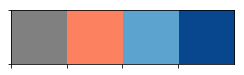

In [2]:
import random
import json
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
from collections import Counter, OrderedDict
import seaborn as sns
sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# COLORS = ["#808080", "#3498db", "#0000b3", "#ffd480", "#e74c3c"]
blues = sns.color_palette('Blues', 10)
reds = sns.color_palette('Reds')
COLORS = ["#808080", reds[2], blues[5], blues[9]]
sns.palplot(sns.color_palette(COLORS))

# from multiprocessing import set_start_method
# try:
#     set_start_method('spawn')
# except RuntimeError:
#     pass

## word neighbors

In [3]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]

# utils:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def invocab(ngram):
    for w in ngram:
        if w not in MATCH:
            return False
    return True

def space(xy, points, delta=1):
    x , y = xy
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    while np.any(np.absolute(xs -x) < delta):
        x += delta
    while np.any(np.absolute(ys -y) < delta):
        y += delta
    return [x, y]

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
sim_wiki = pickle.load(open('../data/Glove/glove_wiki_d300_w15_similarities.pkl',
                             'rb'), encoding='iso-8859-1')
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))
G2_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_matrix_tsne2D.pkl', 'rb'))
G2 = pickle.load(open('../data/Glove/glove_wiki_d300_w15_matrix_tsne2D.pkl', 'rb'))


In [7]:
def cancel_proba(arr, indices):
    arr = arr.copy()
    for i in range(len(arr)):
        if i not in indices:
            arr[i] = 0
    return arr / np.sum(arr)


def plot_words_2d(ax, selected, sim, X2, NN=10, verbose=0, sens=1):
    V = np.arange(sim.shape[0])
    k = MATCH[selected]
    nbrs = sim[k].argsort()[-NN:][::-1]
    p = cancel_proba(sim[k], nbrs)
    samples = np.random.choice(V, p=p, size=(50,))
    xs = X2[samples, 0]
    ys = X2[samples, 1]
    sns.kdeplot(xs, ys, ax=ax, cut=2,
                cmap='Reds', shade=True, shade_lowest=False,
               cbar=False, alpha=.5)
    for i in nbrs:
        if i == k:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=15, color="k", weight=3)
        else:
            ax.text(X2[i,0], X2[i,1], WORDS[i], fontsize=10, color="k")
    plt.tight_layout()

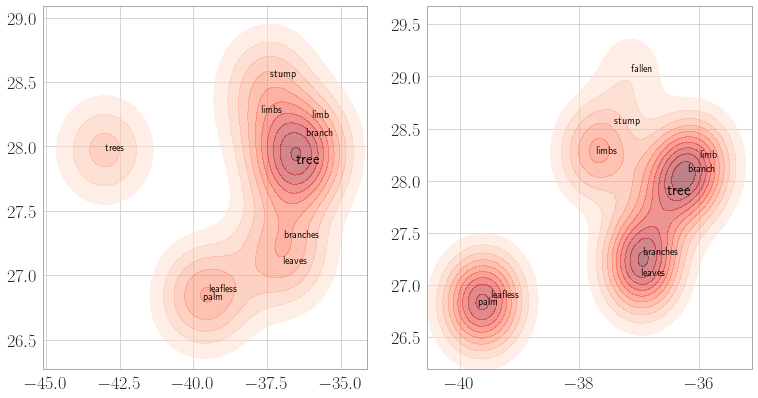

In [8]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
np.random.seed(1)
f, ax = plt.subplots(1,2, figsize=(11,6))
plot_words_2d(ax[0], 'tree', exps(sim_coco, tau=.15), NN=10, X2=G2_coco)
plot_words_2d(ax[1], 'tree', exps(sim_coco, tau=.15, freq=True), NN=10, X2=G2_coco)
plt.savefig('../figures/word_idf_kde.png', dpi=300,
           bbox_iches='tight')

# plt.savefig('../figures/word_kde.png', dpi=300,
#            bbox_iches='tight')

In [23]:
def plot_word_neighbors(axs, selected, sim1, sim2, labels,
                        NN=10, verbose=0, skipMLE=0):
    ax2, ax = axs
    h = .08
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected]
    nbrs1 = np.flip(sim1[k].argsort()[-NN:][::-1], axis=0)
    nbrs2 = np.flip(sim2[k].argsort()[-NN:][::-1], axis=0)
    nbrs = list(set(nbrs1).union(set(nbrs2)))
    nbrs.remove(k)
    nbrs = nbrs + [k]
#     print('neighbors:', nbrs)
    wnbrs = [WORDS[i] for i in nbrs]
    simnbrs1 = [sim1[k,i] for i in nbrs]
    simnbrs2 = [sim2[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(len(nbrs))
    ax2.get_shared_y_axes().join(ax, ax2)
    ax2.set_xlim(1e-6, 1)
    ax2.text(1e-4,-.26,"freq", fontsize=18)
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()
    freqnbrs = [F[i] for i in nbrs]
    if verbose:
        print('freq', freqnbrs)
        print('sim', simnbrs)
    ax2.barh(ys, freqnbrs, height=h,
             align='edge', color=COLORS[1], alpha=.5)
    
    ax2.set_xscale("log", nonposx='clip')
#     ax2.set_xlabel('freq')
    
    ax2.axis('off')
    if not skipMLE:
        denom = 3
        ax.barh(ys+2*h/denom, [0] * (len(nbrs)-1) + [1], height=h/denom,
                align='edge', color=COLORS[0], alpha=.5,
               label="MLE")
    else:
        denom = 2
    ax.barh(ys+h/denom, simnbrs1, height=h/denom,
            align='edge', color=COLORS[2], alpha=.7,
           label=labels[0])
    ax.barh(ys, simnbrs2, height=h/denom,
            align='edge', color=COLORS[3], alpha=.7,
            label=labels[1])
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    if not skipMLE:
        ax.set_xlim(1e-4, 1)
    else:
        ax.set_xlim(min(np.min(simnbrs1), np.min(simnbrs2)),
                    max(np.max(simnbrs1), np.max(simnbrs2)))
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('$r_\\tau(y|$%s$)$' % selected)        
    plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')


(1, 4)


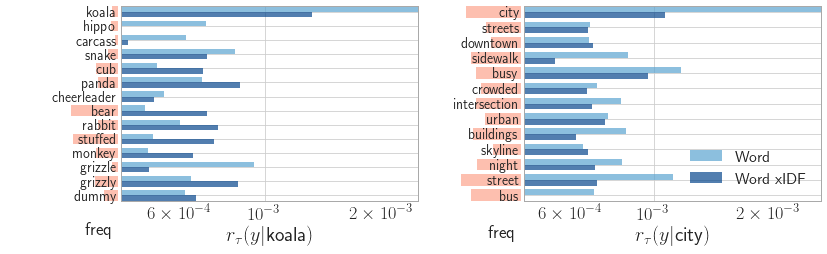

In [41]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

# words = ['city', 'behind', 'yellow', 'koala', 'raining', 'maps', 'poem', 'africa' ]
words = ['koala', 'city']
skipMLE = 1
sim1 = exps(sim_coco, 0.15)
sim2 = exps(sim_coco, 0.15, True)
nr = len(words) // 2
if not len(word) % 2:
    nr += 1
fig, axs = plt.subplots(nr, 4, figsize=(12, 4*nr),
                        gridspec_kw = {'width_ratios':[1, 3] * 2})

if nr == 1:
    axs = axs[np.newaxis,:]
    print(axs.shape)
w = 0
while w < nr:
    plot_word_neighbors(axs[w,:2], words[2*w],
                        sim1, sim2,
                        ['Word', 'Word xIDF'],
                        skipMLE=skipMLE)
    plot_word_neighbors(axs[w,2:4], words[2*w+1],
                        sim1, sim2,
                        ['Word', 'Word xIDF'],
                        skipMLE=skipMLE)
    w += 1
axs[nr-1,3].legend(fontsize=16, loc=4)
fig.tight_layout()
plt.subplots_adjust(wspace=0.02)
plt.savefig('../figures/words_nbrs.png',
            dpi=300, bbox_inches='tight')


In [38]:
frequent = F.argsort()[-100:-80][::-1]
medium = F.argsort()[6300:6320]
rare = F.argsort()[60:70]

for fr in medium:
    print(WORDS[fr],)

native
handicap
medicine
captivity
archway
projector
yummy
dense
readies
rod
sparsely
removing
machinery
wiping
raining
pours
cant
airstrip
divided
bottled


In [ ]:
def skim(arr, percentile):
    th = np.percentile(arr, percentile)
    arr[arr<th] = 0
    return arr

def plot_nbrs_picks(word, ax, legend=False):
    iw = MATCH[word]
    dirac = np.zeros(sim_coco.shape[0])
    dirac[MATCH[word]] = 1
    ax.plot(dirac, c='darkred', alpha=0.5, label="MLE - $\\delta$")

    default = skim(exps(sim_coco, 0.15, False)[iw], 99.5)
    ax.plot(default, c='darkgreen', label="Tok-Reward - $r_\\tau$", alpha=.5)

    xidf = skim(exps(sim_coco, 0.15, True)[iw], 99.5)
    ax.plot(xidf, c='mediumblue', label="Tok-Reward - $r_\\tau^{IDF}$", alpha=.5)
    if legend:
        ax.legend(fontsize=15, loc=2)
    wxidf = np.nonzero(xidf)[0]
    wdef = np.nonzero(default)[0]
    wperr = 4
    sel = np.concatenate((np.array([iw]),
                          np.random.choice(wdef, wperr),
                          np.random.choice(wxidf, wperr)))
    colors = ['darkred'] + wperr * ['darkgreen'] + wperr * ['mediumblue']
    for e, (s, c) in enumerate(zip(sel, colors)):
#         print('index:', s, 'default', default[s], 'xidf', xidf[s])
        if not e:
            scale=.5
            slide = 25
            pick = 1
        else:
            if e < wperr + 1:
                pick = default[s]
                slide = -400
                scale = 5
#                 print('e:', e, WORDS[s])
            else:
                pick = xidf[s]
                slide = 100
                scale = 3

        ax.annotate(WORDS[s].encode().decode(),
                    xy=(s, pick),
                    xytext=(s + slide, scale * pick),
                    color=c,
                    fontsize=18,
    #               arrowprops=dict(facecolor='black', shrink=0.05),
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    facecolor=c,
                                    edgecolor=c))
    ax.set_yscale("log")
    ax.set_xticks([])
    ax.set_ylabel('$r_\\tau(y|$%s$)$' % word)
#     ax.set_xlabel('$\\mathcal V$')


In [ ]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, axs = plt.subplots(2, 1, figsize=(15, 5))
np.random.seed(1244)
plot_nbrs_picks('street', axs[0], legend=True)

np.random.seed(17)
plot_nbrs_picks('dynamite', axs[1])

plt.tight_layout()
# plt.savefig('../figures/nbrs_picks.png',
#             dpi=300, bbox_inches='tight')